# Helium, Dark Matter and Reionization

In this part of the notebook, we will show several different examples of how to evaluate the temperature and ionization histories using many of the different options available to `DarkHistory`. The function that solves the differential equations is `darkhistory.tla.get_history`, and the set of equations that is solved can be compactly written as follows:

$$ \dot{T}_m = \dot{T}_m^{(0)} + \dot{T}_m^{\text{inj}} + \dot{T}_m^\text{reion} $$

$$ \dot{x}_\text{HII} = \dot{x}_\text{HII}^{(0)} + \dot{x}_\text{HII}^{\text{inj}} + \dot{x}_\text{HII}^\text{reion} $$

$$ \dot{x}_\text{HeII} = \dot{x}_\text{HeII}^{(0)} + \dot{x}_\text{HeII}^{\text{inj}} + \dot{x}_\text{HeII}^\text{reion} $$

with each of the terms defined in the paper.

## Notebook Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [55]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc_file('matplotlibrc')


import numpy as np
from scipy.interpolate import interp1d

import darkhistory.physics as phys
import darkhistory.history.tla as tla

## Standard Ionization and Temperature Histories

The most basic use of `get_history` is to obtain the standard ionization and temperature histories with no exotic energy injection sources or reionization. In the simplest approximation, we can neglect helium and simply evaluate the following equations:

$$ \dot{T}_m = \dot{T}_m^{(0)}, \qquad \dot{x}_\text{HII} = \dot{x}_\text{HII}^{(0)} $$

First, we initialize the redshift abscissa. This must be defined in decreasing redshift. Note that the transfer functions used in calculating $f_c(z)$ only span a redshift range of $4 \leq 1+z \leq 3000$. In this example, we solve the TLA from $1+z = 3000$ to $1+z = 1$. 

First, we define a redshift vector at which we would like to find the solution. 

In [ ]:
rs_vec = np.flipud(1 + np.arange(3000))

The three-level atom (TLA) model is a set of coupled differential equations governing the ionization and thermal history of the universe. In it's original form as proposed by Peebles <cite data-cite="6232408/DVUAUQGP"></cite> and Zel'dovich et al. <cite data-cite="6232408/VV5Y8E88"></cite>, it assumes that the universe is entirely composed of hydrogen atoms with three levels: $n = 1$, $n = 2$ and the continuum, and that the only additional source of photons is the CMB blackbody radiation. A more recent explanation of this model is given in <cite data-cite="6232408/HNJVBBSZ"></cite>.



The TLA has been successfully modified to include dark matter energy injection <cite data-cite="6232408/SPGPKD33"></cite>. This is done by introducing the ratio $f_c(z)$ of the energy injection rate due to DM annihilation/decay to the energy deposition rate into the IGM from these injections, in a given channel $c$ (ionization of hydrogen, excitation of hydrogen, or collisional heating of the IGM):

$$ \left( \frac{dE}{dV \, dt} \right)_{\text{dep.}, c} = f_c(z) \left( \frac{dE}{dV \, dt} \right)_{\text{inj.}, c} $$

Calculating $f_c(z)$ for use in these equations is one of the key goals of DarkHistory.

The TLA with DM is included in DarkHistory and reionization can be solved to give the ionization and thermal history of the universe with DM energy injection and a reionization model. Our TLA solver includes a fudge factor in the recombination coefficient to the $n=2$ levels recommended by <cite data-cite="6232408/HNJVBBSZ"></cite> for good agreement with HyRec. Furthermore, we solve the TLA equations in terms of $y \equiv \text{arctanh}[2(x_e - 0.5)]$, which makes the differential equations less stiff, and also guarantees that the ionization fraction $x_e$ is bounded between 0 and 1. 

---

## `history.tla.get_history`

The function that solves the TLA is `tla.get_history`.

We will first solve the equation with no dark matter injection and no reionization model.

First, we initialize the redshift abscissa. This must be defined in decreasing redshift. Note that the transfer functions used in calculating $f_c(z)$ only span a redshift range of $4 \leq 1+z \leq 3000$. We recommend that integration of the TLA should begin no earlier than $1+z = 3000$ for the default solver parameters that we use. 

In this example, we solve the TLA from $1+z = 3000$ to $1+z = 1$. 

In [3]:
rs_vec_std = np.flipud(1 + np.arange(3000))

Next, we set the initial conditions. This is a list of four floats ($T_m$, $x_\mathrm{HII}$, $x_\mathrm{HeII}$, $x_\mathrm{HeIII}$). Well before recombination, we can safely take $T_m = T_\mathrm{CMB}$ and $x_\mathrm{HII} = 1$. For this version of the code, we always take $x_\mathrm{HeII} = x_\mathrm{HeIII} = 0$, with no evolution in these fractions until reionization begins (note that the code actually sets any electron fraction that is specified to be 0 to a small number `1. - 1e-12` internally, so that $y$ remains finite).

In [57]:
init_cond = np.array([phys.TCMB(3000), phys.xe_Saha(3000, 'HI'), phys.xe_Saha(3000, 'HeI') - 1., 0])

We are now ready to call `tla.get_history`. The function is called using the following syntax:

```python
def get_history(
    init_cond, f_H_ion_in, f_H_exc_in, f_heating_in,
    dm_injection_rate_in, rs_vec, reion_switch=True, reion_rs=None,
    photoion_rate_func=None, photoheat_rate_func=None,
    mxstep = 1000
)
```

The arguments are as follows: 

1. `init_cond` is the initial conditions which we have defined above.

2. `f_H_ion_in`, `f_H_exc_in`, `f_heating_in` and `dm_injection_rate_in` are all parameters related to dark matter energy injection; we set them to zero in this part of the example. 

3. `rs_vec_std` is the redshift array over which to solve the TLA. Note that numerical errors may be reported by the ODE solver if `rs_vec_std` is spaced too widely. 

4. `reion_switch` determines if a reionization model should be used, and `reion_rs`, `photoion_rate_func` and `photoheat_rate_func` are parameters related to reionization. We shall set `reion_switch=False` for now.

5. Finally, `mxstep` is the maximum number of steps that the integrator can take per integration point. Increasing this may allow the solver to overcome integration errors, while decreasing this value may speed up the integration.

Now, let's call the function!

In [58]:
soln = tla.get_history(rs_vec_std, init_cond, 0., 0., 0., 0., reion_switch=False, helium_TLA=True)

The solution is returned as an array with dimensions `(rs_vec_std.size, 4)`. Each column corresponds to the solution for ($T_m$ in eV, $x_\mathrm{HII}$, $x_\mathrm{HeII}$, $x_\mathrm{HeIII}$. Let's plot the solution. 

[1400.0, 3000.0, 0.95, 1.13]

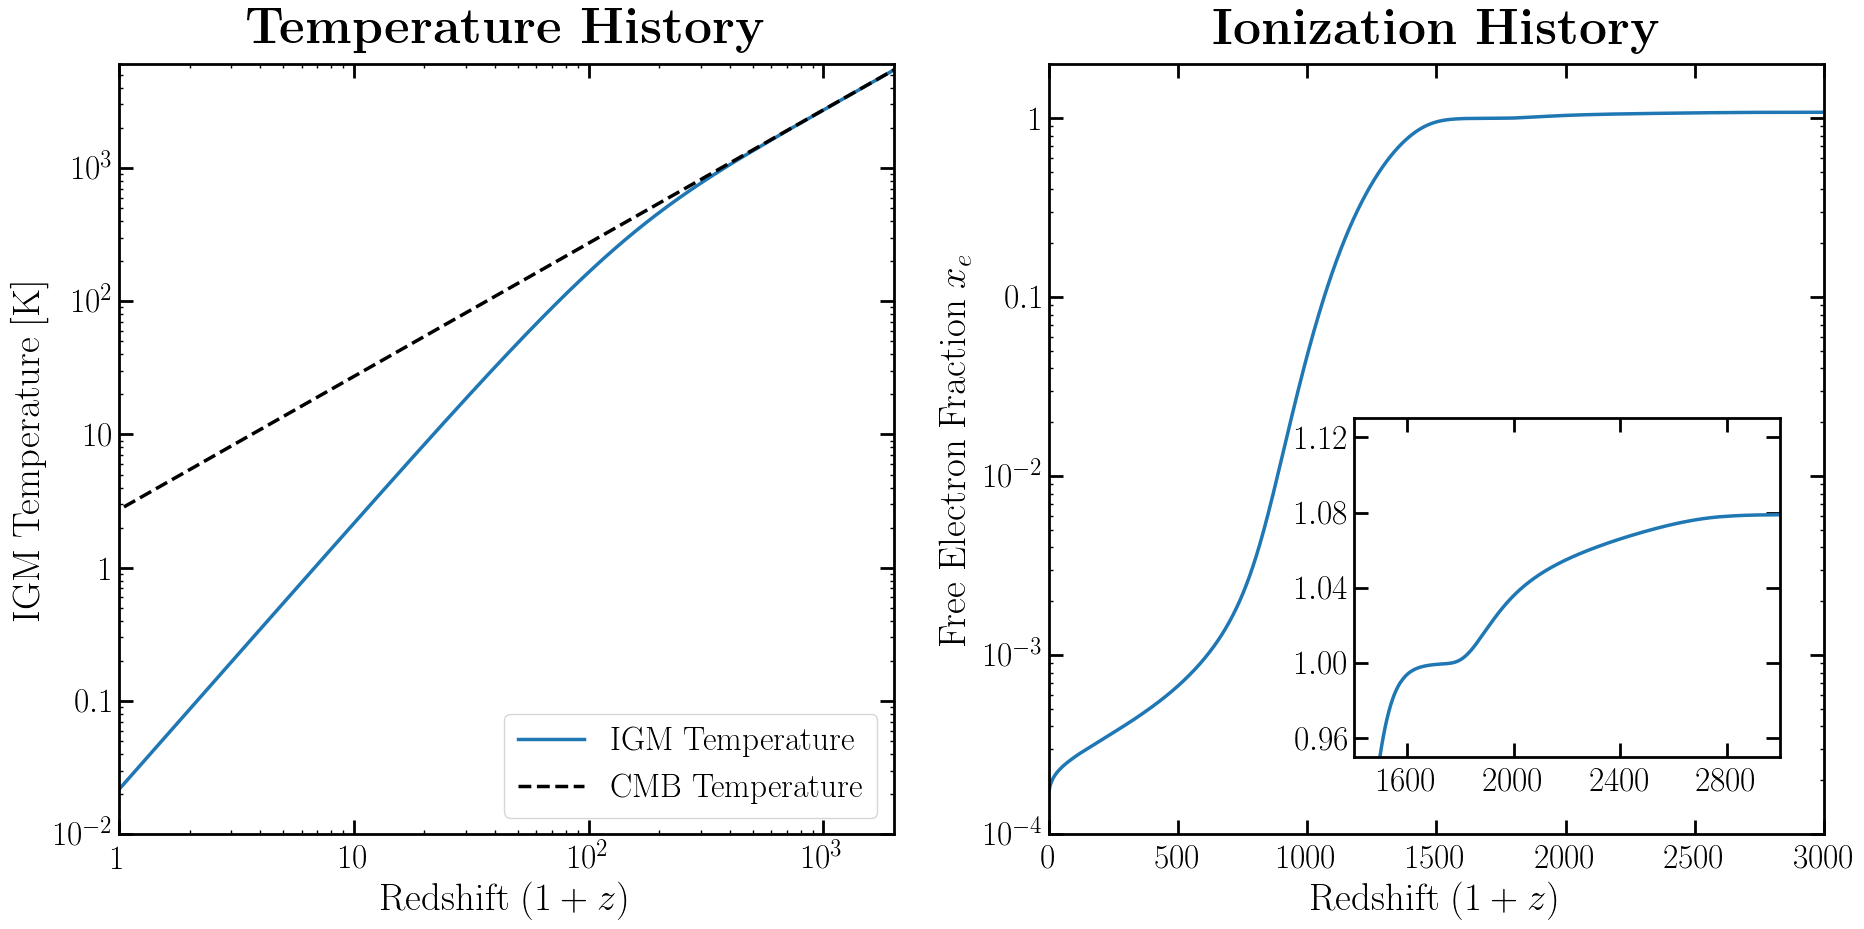

In [59]:
soln_Tm = soln[:,0]/phys.kB
soln_xHII = soln[:,1] + soln[:,2]

fig = plt.figure(figsize=(22,10))

ax = plt.subplot(1,2,1)

T_IGM, = plt.plot(rs_vec_std, soln_Tm, label='IGM Temperature')
T_CMB, = plt.plot(rs_vec_std, phys.TCMB(rs_vec_std)/phys.kB, 'k--', label='CMB Temperature')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[T_IGM, T_CMB], loc=4)


plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel('IGM Temperature [K]')
plt.axis([1, 2e3, 1e-2, 6e3])

ax = plt.subplot(1,2,2)

plt.plot(rs_vec_std, soln_xHII)

# ax.set_xscale('log')
ax.set_yscale('log')

plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Free Electron Fraction $x_e$')
plt.axis([1, 3e3, 1e-4, 2])

from matplotlib.transforms import blended_transform_factory
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

transform = blended_transform_factory(fig.transFigure, ax.transAxes)
axins4 = inset_axes(ax,  width="22%", height="50%",
                    bbox_to_anchor=(0, 0.1, 0.88, 0.88),
                    bbox_transform=transform, loc=4, borderpad=0)

plt.plot(rs_vec_std, soln_xHII)
plt.yticks([0.96, 1., 1.04, 1.08, 1.12])
plt.xticks([1600, 2000, 2400, 2800])
plt.axis([1.4e3, 3e3, 0.95, 1.13])


## Reionization

A default reionization model is included with `DarkHistory`. This model combines the fiducial photoionization and photoheating rates provided in <cite data-cite="6232408/MJ7LY7BF"></cite> with rates for collisional ionization, collisional excitation, recombination cooling and Bremsstrahlung cooling given in <cite data-cite="6232408/4FF4XZAM"></cite>, in order to obtain the ionization/temperature change during reionization. Although the results of <cite data-cite="6232408/MJ7LY7BF"></cite> are meant for large scale simulations of reionization, `DarkHistory` is able to obtain excellent agreement with their fiducial temperature/ionization history using this method. 

The code for the model can be found in `darkhistory.history.reionization`.

To obtain the temperature/ionization history with the default reionization model, simply specify `reion_switch = True`.

In [ ]:
%autoreload
# Initialize the redshift at which we want the solution. 
rs_vec = np.flipud(1 + np.arange(0, 3000, 0.1))

# Set the initial conditions. The initial temperature is the CMB temperature, 
# and the initial free electron fraction is 1. 
init_cond = np.array([phys.TCMB(3000), phys.xe_Saha(3000, 'HI'), phys.xe_Saha(3000, 'HeI') - 1., 0])

# Obtain the solution.
soln_with_reion = tla.get_history(init_cond, 0., 0., 0., 0., rs_vec, reion_switch=True, helium_TLA=True)

And now plot the results. These results should be compared to Fig. 6 of <cite data-cite="6232408/MJ7LY7BF"></cite> and are in good agreement.

In [ ]:
plt.figure(figsize=(22,10))

ax = plt.subplot(1,2,1)
plt.rc('text', usetex=True)

T_IGM_reion, = plt.plot(rs_vec, soln_with_reion[:,0]/phys.kB, label='Standard Reionization')

plt.legend(handles=[T_IGM_reion])

plt.title('Temperature History')
plt.xlabel('Redshift (1+z)')
plt.ylabel('IGM Temperature [K]')
plt.axis([1, 17, 0, 20000])

ax = plt.subplot(1,2,2)

xHII, = plt.plot(rs_vec, soln_with_reion[:,1], linewidth=2, label=r'$n_\mathrm{HII}/n_\mathrm{H}$')
xHeII, = plt.plot(rs_vec, soln_with_reion[:,2]/(phys.nHe/phys.nH), linewidth=2, label=r'$n_\mathrm{HeII}/n_\mathrm{He}$')
xHeIII, = plt.plot(rs_vec, soln_with_reion[:,3]/(phys.nHe/phys.nH), linewidth=2, label=r'$n_\mathrm{HeIII}/n_\mathrm{He}$')

leg = plt.legend(handles=[xHII, xHeII, xHeIII])
leg.set_title('Standard Reionization', prop = {'size':'28'})

plt.title('Ionization History')
plt.xlabel('Redshift (1+z)')
plt.ylabel('Ionization Fraction')
plt.axis([1, 17, 0, 1.2])


## User-Defined Reionization

The user may enter their own photoionization and photoheating rates into the TLA solver. This is done by defining two tuples of functions, each containing the photoionization and photoheating rates respectively of HI, HeI and HeII. Here, we define functions `photoion_rate` and `photoheat_rate` to return these tuples, given some new photoionization and photoheating rates. In this example, we use the rates from <cite data-cite="6232408/QRY4E9Y7"></cite>.

In [ ]:
def photoion_rate():
    
    rs_vec = 1. + np.array([
        0.00, 0.05, 0.10, 0.16, 0.21, 0.27, 0.33, 0.40, 0.47,
        0.54, 0.62, 0.69, 0.78, 0.87, 0.96, 1.05, 1.15, 1.26, 
        1.37, 1.49, 1.61, 1.74, 1.87, 2.01, 2.16, 2.32, 2.48,
        2.65, 2.83, 3.02, 3.21, 3.42, 3.64, 3.87, 4.11, 4.36,
        4.62, 4.89, 5.18, 5.49, 5.81, 6.14, 6.49, 6.86, 7.25,
        7.65, 8.07, 8.52, 8.99, 9.48, 9.99, 10.50, 11.10, 11.70,
        12.30, 13.00, 13.70, 14.40, 15.10
    ])
    
    rate_vec_HI = np.array([
        22.8, 28.4, 35.4, 44.0, 54.6, 67.4, 83.1, 102, 125,
        152, 185, 223, 267, 318, 376, 440, 510, 585, 660, 732, 
        799, 859, 909, 944, 963, 965, 950, 919, 875, 822, 765, 
        705, 647, 594, 546, 504, 469, 441, 412, 360, 293, 230,
        175, 129, 92.8, 65.5, 45.6, 31.2, 21.2, 14.3, 9.59, 
        6.40, 4.27, 2.92, 1.73, 1.02, 0.592, 0.341, 0.194
    ]) * 1e-15
    
    rate_vec_HeI = np.array([
        12.4, 15.7, 19.6, 24.6, 30.7, 38.3, 47.5, 58.7, 72.2,
        88.4, 108, 130, 157, 187, 222, 261, 302, 346, 391, 
        434, 474, 509, 538, 557, 567, 566, 555, 535, 508,
        476, 441, 406, 372, 341, 314, 291, 271, 253, 237, 214,
        184, 154, 125, 99.2, 76.1, 56.8, 41.4, 29.6, 20.7, 
        14.4, 9.82, 6.67, 4.53, 3.24, 2.02, 1.23, 0.746, 0.446,
        0.262
    ]) * 1e-15
    
    rate_vec_HeII = np.array([
        0.555, 0.676, 0.823, 1.00, 1.22, 1.48, 1.80, 2.18,
        2.63, 3.17, 3.80, 4.54, 5.38, 6.33, 7.38, 8.52, 
        9.70, 10.9, 11.9, 12.7, 13.2, 13.4, 13.3, 12.8, 
        11.9, 10.6, 9.04, 7.22, 5.30, 3.51, 2.08, 1.14,
        0.591, 0.302, 0.152, 0.0760, 0.0375, 0.0182,
        0.00857, 0.00323, 0.00117, 4.42e-4, 1.73e-4, 
        7.01e-5, 2.92e-5, 1.25e-5, 5.67e-6, 2.74e-6, 1.44e-6,
        8.19e-7, 4.99e-7, 3.25e-7, 2.12e-7, 1.43e-7, 9.84e-8,
        6.81e-8, 4.73e-8, 3.30e-8, 1.92e-8
    ]) * 1e-15

    def ion_rate_HI(rs):
        log10_rate = np.interp(rs, rs_vec, np.log10(rate_vec_HI))
        return 10**log10_rate
    
    def ion_rate_HeI(rs):
        log10_rate = np.interp(rs, rs_vec, np.log10(rate_vec_HeI))
        return 10**log10_rate
    
    def ion_rate_HeII(rs):
        log10_rate = np.interp(rs, rs_vec, np.log10(rate_vec_HeII))
        return 10**log10_rate

    return (ion_rate_HI, ion_rate_HeI, ion_rate_HeII)

def photoheat_rate():
    
    rs_vec = 1. + np.array([
        0.00, 0.05, 0.10, 0.16, 0.21, 0.27, 0.33, 0.40, 0.47,
        0.54, 0.62, 0.69, 0.78, 0.87, 0.96, 1.05, 1.15, 1.26, 
        1.37, 1.49, 1.61, 1.74, 1.87, 2.01, 2.16, 2.32, 2.48,
        2.65, 2.83, 3.02, 3.21, 3.42, 3.64, 3.87, 4.11, 4.36,
        4.62, 4.89, 5.18, 5.49, 5.81, 6.14, 6.49, 6.86, 7.25,
        7.65, 8.07, 8.52, 8.99, 9.48, 9.99, 10.50, 11.10, 11.70,
        12.30, 13.00, 13.70, 14.40, 15.10
    ])
    
    rate_vec_HI = np.array([
        8.89, 11.1, 13.9, 17.3, 21.5, 26.6, 32.9, 40.5, 49.6, 
        60.5, 73.4, 88.5, 106, 126, 149, 175, 203, 232, 262,
        290, 317, 341, 360, 374, 381, 382, 375, 363, 346, 325,
        302, 279, 257, 236, 218, 202, 189, 178, 167, 148, 123,
        98.9, 77.1, 58.3, 43.0, 31.0, 21.9, 15.3, 10.5, 7.13, 
        4.81, 3.23, 2.17, 1.51, 0.915, 0.546, 0.323, 0.189, 0.110
    ]) * 1e-14
    
    rate_vec_HeI = np.array([
        11.2, 14.0, 17.4, 21.6, 26.7, 33.1, 40.8, 50.2, 61.5,
        75.1, 91.1, 110, 132, 157, 186, 217, 251, 287, 323, 
        357, 387, 413, 432, 444, 446, 438, 422, 398, 368, 336,
        304, 274, 249, 227, 209, 194, 181, 170, 160, 146, 130, 
        112, 95.2, 78.3, 62.5, 48.3, 36.3, 26.6, 19.1, 13.4, 
        9.27, 6.36, 4.35, 3.14, 1.98, 1.22, 0.749, 0.455, 0.270
    ])* 1e-14

    rate_vec_HeII = np.array([
        1.14, 1.38, 1.68, 2.03, 2.45, 2.96, 3.57, 4.29, 5.14,
        6.15, 7.32, 8.67, 10.2, 11.9, 13.9, 15.9, 18.1, 20.2,
        22.1, 23.7, 24.7, 25.3, 25.2, 24.4, 22.9, 20.7, 17.8,
        14.5, 11.1, 7.75, 4.97, 2.96, 1.68, 0.925, 0.501, 0.267,
        0.141, 0.0727, 0.0365, 0.0156, 0.00624, 0.00269, 0.00128,
        6.74e-4, 3.88e-4, 2.40e-4, 1.55e-4, 1.03e-4, 6.98e-5, 
        4.76e-5, 3.26e-5, 2.24e-5, 1.53e-5, 1.06e-5, 7.52e-6,
        5.31e-6, 3.73e-6, 2.57e-6, 1.54e-6
    ]) * 1e-14

    def heat_rate_HI(rs):
        log10_rate = np.interp(rs, rs_vec, np.log10(rate_vec_HI))
        return 10**log10_rate
    
    def heat_rate_HeI(rs):
        log10_rate = np.interp(rs, rs_vec, np.log10(rate_vec_HeI))
        return 10**log10_rate
    
    def heat_rate_HeII(rs):
        log10_rate = np.interp(rs, rs_vec, np.log10(rate_vec_HeII))
        return 10**log10_rate

    return (heat_rate_HI, heat_rate_HeI, heat_rate_HeII)



Now we call the solver. In addition to setting `reion_switch=True`, we must also specify the redshift at which reionization effects start (`reion_rs`), as well as the two tuples for `photoion_rate_func` and `photoheat_rate_func` respectively.

In [ ]:
%autoreload
# Initialize the redshift at which we want the solution. 
rs_vec_reion = np.flipud(1 + np.arange(0, 3000, 0.1))

# Set the initial conditions. The initial temperature is the CMB temperature, 
# and the initial free electron fraction is 1. 
init_cond = np.array([phys.TCMB(3000), phys.xe_Saha(3000, 'HI'), phys.xe_Saha(3000, 'HeI') - 1., 0])

# Obtain the solution
soln_with_reion_2 = tla.get_history(
    rs_vec_reion, init_cond, 0., 0., 0., 0., helium_TLA=True,
    reion_switch=True, reion_rs = 16.1, photoion_rate_func=photoion_rate(), photoheat_rate_func=photoheat_rate()
)

And now plot the result, which again is in good agreement with Fig. 6 of <cite data-cite="6232408/MJ7LY7BF"></cite>

In [ ]:
plt.figure(figsize=(22,10))

ax = plt.subplot(1,2,1)
plt.rc('text', usetex=True)

T_IGM_Puchwein, = plt.plot(rs_vec_reion, soln_with_reion[:,0]/phys.kB, label='Puchwein+ (Std.)')
T_IGM_Haardt, = plt.plot(rs_vec_reion, soln_with_reion_2[:,0]/phys.kB, label='Haardt+')

plt.legend(handles=[T_IGM_Puchwein, T_IGM_Haardt])


plt.title(r'\bf{Temperature History}')
plt.xlabel('Redshift (1+z)')
plt.ylabel('IGM Temperature [K]')
plt.axis([1, 17, 0, 20000])

ax = plt.subplot(1,2,2)

xHII_Puchwein, = plt.plot(rs_vec_reion, soln_with_reion[:,1], label=r'$n_\mathrm{HII}/n_\mathrm{H}$, Puchwein+ (Std.)')
xHII_Haardt, = plt.plot(rs_vec_reion, soln_with_reion_2[:,1], label=r'$n_\mathrm{HII}/n_\mathrm{H}$, Haardt+')
xHeIII_Puchwein, = plt.plot(rs_vec_reion, soln_with_reion[:,3]/(phys.nHe/phys.nH), label=r'$n_\mathrm{HeIII}/n_\mathrm{He}$, Puchwein+ (Std.)')
xHeIII_Haardt, = plt.plot(rs_vec_reion, soln_with_reion_2[:,3]/(phys.nHe/phys.nH), label=r'$n_\mathrm{HeIII}/n_\mathrm{He}$, Haardt+')

plt.legend(handles=[xHII_Puchwein, xHII_Haardt, xHeIII_Puchwein, xHeIII_Haardt], loc=1)

plt.title(r'\bf{Ionization History}')
plt.xlabel('Redshift (1+z)')
plt.ylabel('Ionization Fraction')
plt.axis([1, 17, 0, 1.5])


## Dark Matter

Now, we will introduce dark matter into the TLA equations. We introduce a dark matter species with mass $m_\chi = $ 100 MeV that decays with some (long) lifetime into an $e^+e^-$ pair. The energy injection rate is:

$$ \left( \frac{dE}{dV \, dt} \right)_{\text{inj.}} = \frac{\rho_{\text{DM},0}}{\tau} (1 + z)^3  $$

where $\tau$ is the lifetime, and $\rho_{\text{DM},0}$ is the dark matter density today. 

`get_history` requires four inputs in order to solve the TLA with DM injection: three functions that describe $f_c(z)$ as a function of redshift, $x_\mathrm{HI}$, $x_\mathrm{HeI}$ and $x_\mathrm{HeII}$, with $c$ indexing hydrogen ionization, hydrogen excitation and collisional heating, as well as the dark matter energy injection rate.

In this example, we will use the $f_c(z)$ computed in <cite data-cite="6232408/S55R7ACJ"></cite>, which assumes the default RECFAST ionization history and is therefore only dependent on redshift <span style="color:red">(HL: this needs to be true eventually)</span>. We will show in Example <span style="color:red">(HL: specify)</span> the histories with the same DM parameters, but with $f_c(z)$ computed with backreaction fully taken into account.

First, let's define the $f_c(z)$ functions.


In [60]:
# Import f's

from scipy.interpolate import interp2d

mDM = 1e8

fz_elec_decay = np.loadtxt('/Users/hongwan/Dropbox (MIT)/21cm_pwave/TLA_code/fz_electron_decay.dat', delimiter=',')

log10rs  = fz_elec_decay[0:70, 1]
log10eng = fz_elec_decay[0:2800:70, 0] 

log10f_elec_decay = {
    'H_ion':   np.transpose(np.reshape(fz_elec_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_decay[11200:14000,2], (40,70))) 
}


def f_H_ion(rs, xHI, xHeI, xHeII):
    
    interp_func = interp2d(log10eng, log10rs, log10f_elec_decay['H_ion'])
    return 10**interp_func(np.log10(mDM), np.log10(rs))

def f_H_exc(rs, xHI, xHeI, xHeII):
    interp_func = interp2d(log10eng, log10rs, log10f_elec_decay['H_exc'])
    return 10**interp_func(np.log10(mDM), np.log10(rs))

def f_heating(rs, xHI, xHeI, xHeII):
    interp_func = interp2d(log10eng, log10rs, log10f_elec_decay['heating'])
    return 10**interp_func(np.log10(mDM), np.log10(rs))


Next, we define the function that returns the DM energy injection rate. This function should only depend on redshift. Here, we have chosen decaying dark matter with a lifetime of $\tau = 10^{25}$ s. These values of $\tau$ and $m_\chi$ are consistent with existing CMB constraints on DM decay <cite data-cite="6232408/VKMX8MFJ"></cite>, and may be able to make an order 10\% contribution to reionization at $z = 6$ [see Fig. 15 of <cite data-cite="6232408/3KKTSI4D"></cite>]. 

In [61]:
# The user may also choose to use `physics.inj_rate` to construct this function.
def dm_injection_rate(rs):
    # Set the desired lifetime here in seconds. 
    tau = 1e25
    return phys.rho_DM*rs**3/tau

Now call the solver, with initial conditions and the redshift array. We will first solve it without reionization turned on.

In [62]:
# Initialize the redshift at which we want the solution. 
rs_vec = np.flipud(4.02 + np.arange(0, 2994, 0.1))
# Set the initial conditions. Setting the initial condition to be 1 will result in an error. 
init_cond = [phys.TCMB(2997.92), 1, 0, 0]

print(rs_vec)

# Obtain the solution
soln_DM = tla.get_history(rs_vec, init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, reion_switch=False)

[2997.92 2997.82 2997.72 ...    4.22    4.12    4.02]


The result is shown below.

[4, 3000.0, 0.0001, 2]

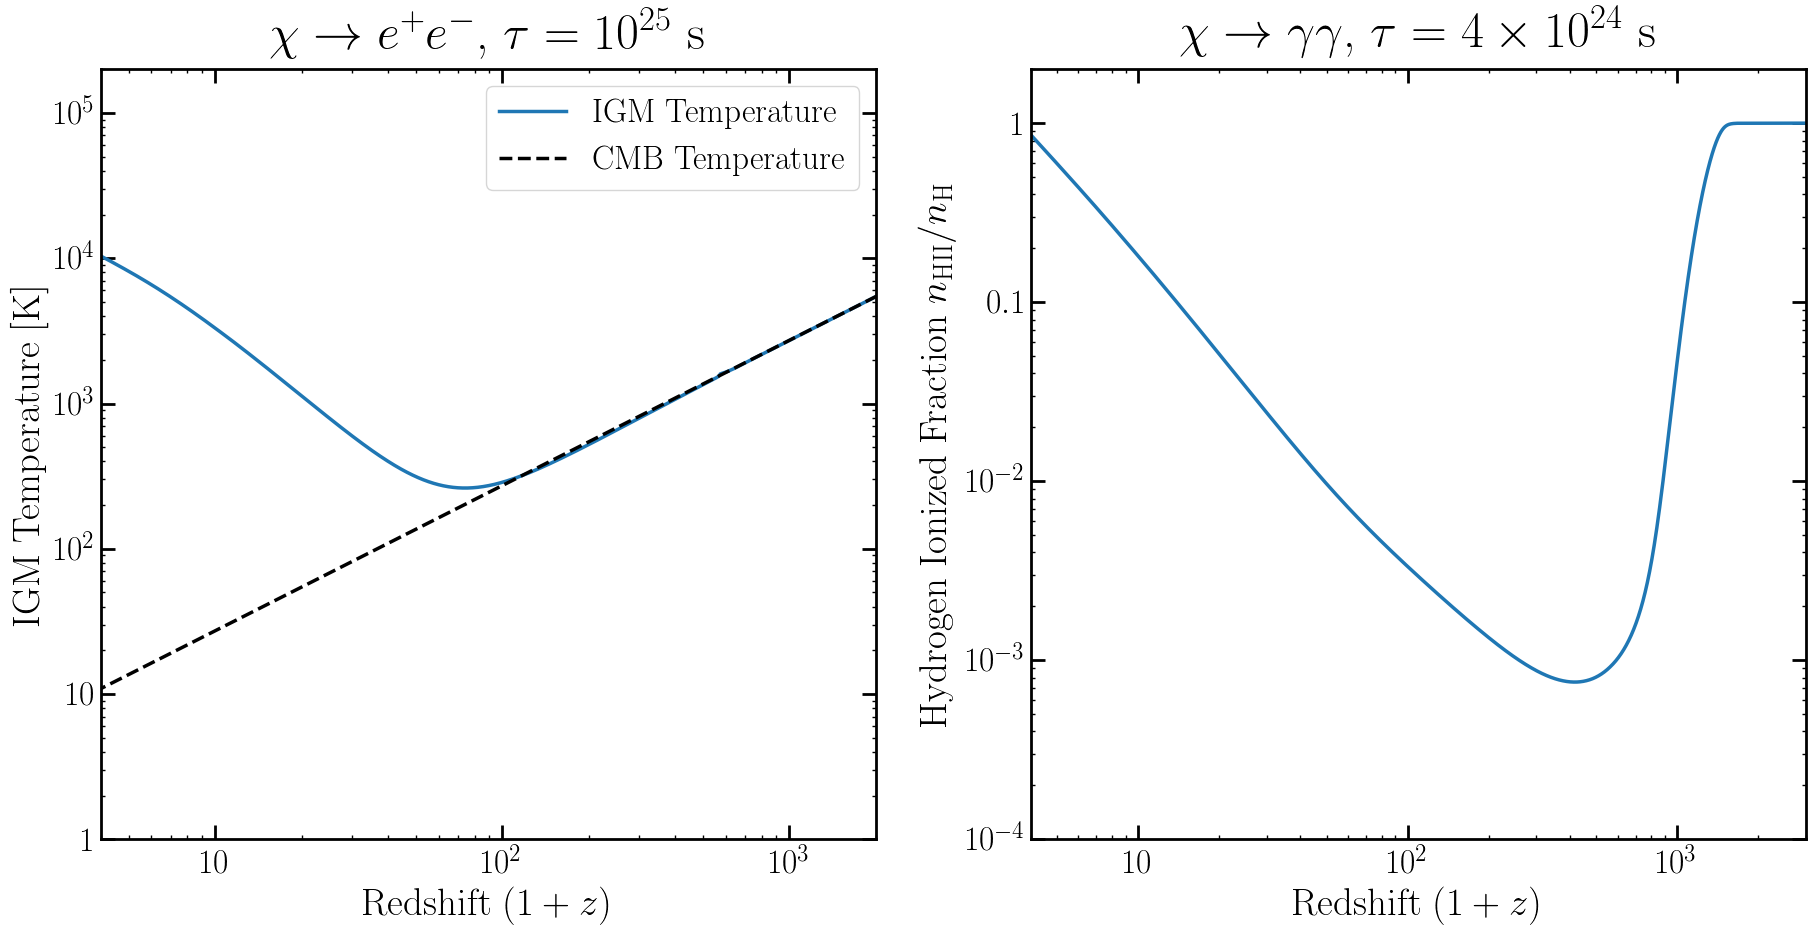

In [63]:
soln_Tm = soln_DM[:,0]/phys.kB
soln_xHII = soln_DM[:,1]

plt.figure(figsize=(22,10))

ax = plt.subplot(1,2,1)

T_IGM, = plt.plot(rs_vec, soln_Tm, label='IGM Temperature')
T_CMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='CMB Temperature')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[T_IGM, T_CMB])


plt.title(r'$\chi \to e^+e^-$, $\tau = 10^{25}$ s')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel('IGM Temperature [K]')
plt.axis([4, 2e3, 1, 2e5])

ax = plt.subplot(1,2,2)

plt.plot(rs_vec, soln_xHII)

ax.set_xscale('log')
ax.set_yscale('log')


plt.title(r'$\chi \to \gamma \gamma$, $\tau = 4 \times 10^{24}$ s')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Hydrogen Ionized Fraction $n_\mathrm{HII}/n_\mathrm{H}$')
plt.axis([4, 3e3, 1e-4, 2])

Of course, DM energy injection can be combined with a reionization model in `get_history`. Here, we solve the TLA again with the standard reionization scenario of the code. 

In [ ]:
%autoreload
# Initialize the redshift at which we want the solution. 
rs_vec_DM_reion = np.flipud(np.arange(4, 3000.2, 0.2))
# Set the initial conditions. Setting the initial condition to be 1 will result in an error. 
init_cond = np.array([phys.TCMB(3000), phys.xe_Saha(3000, 'HI'), phys.xe_Saha(3000, 'HeI') - 1., 0])

# Obtain the solution
soln_DM_reion = tla.get_history(
    rs_vec_DM_reion, init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, reion_switch=True, helium_TLA=True)

And plotting the results,

In [ ]:
plt.figure(figsize=(22,10))

ax = plt.subplot(1,2,1)
plt.rc('text', usetex=True)

T_IGM_no_DM_reion, = plt.plot(rs_vec_reion, soln_with_reion[:,0]/phys.kB, label='no DM, with reionization', linestyle='--')
T_IGM_DM_reion, = plt.plot(rs_vec_DM_reion, soln_DM_reion[:,0]/phys.kB, label='with DM and reionization')
T_IGM_DM_no_reion, = plt.plot(rs_vec, soln_DM[:,0]/phys.kB, label='with DM, no reionization', linestyle='-.')


# ax.set_yscale('log')

plt.legend(handles=[T_IGM_no_DM_reion, T_IGM_DM_no_reion, T_IGM_DM_reion])


plt.title(r'$\chi \to e^+e^-$, $\tau = 10^{25}$ s')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel('IGM Temperature [K]')
plt.axis([4, 18, 5e2, 2.5e4])
# plt.axis([5, 18, 5e2, 2e4])

ax = plt.subplot(1,2,2)

xHI_no_DM_reion, = plt.plot(rs_vec_reion, 1 - soln_with_reion[:,1], label='no DM, with reionization', linestyle='--')
xHI_DM_reion, = plt.plot(rs_vec_DM_reion, 1 - soln_DM_reion[:,1], label='with DM and reionization')
xHI_DM_no_reion, = plt.plot(rs_vec, 1 - soln_DM[:,1], label='with DM, no reionization', linestyle='-.')


ax.set_yscale('log')

plt.legend(handles=[xHI_no_DM_reion, xHI_DM_no_reion, xHI_DM_reion], loc=4)

plt.title(r'$\chi \to e^+e^-$, $\tau = 10^{25}$ s')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Neutral Fraction $n_\mathrm{HI}/n_\mathrm{H}$')
plt.axis([4, 17, 1e-4, 2.])




Alternatively, the user can specify their own fixed ionization history, with $T_m$ being the only variable integrated with respect to redshift. As before, the user must specify `reion_rs`, the redshift at which the reionization model starts, and a function for $x_e$. Here, we choose the standard $\tanh$ model matched onto the standard ionization history saved in `soln_xHII` above.

In [ ]:
# Define the standard ionization history as an interpolation function for convenience. 

def xe_reion_func(rs):
    # Parameters of the model.
    
    f = 1.08
    delta_z = 0.5
    delta_y = 1.5*rs**0.5*delta_z
    z_re = 8.8
    y = rs**(3/2)
    y_re = (1 + z_re)**(3/2)
    
    reion_model_xe = (f/2)*(1 + np.tanh((y_re - y)/delta_y))
    reion_model_xe[reion_model_xe > 1] == 1.0
    
    return reion_model_xe

In [ ]:
def dm_injection_rate(rs):
    # Set the desired lifetime here in seconds. 
    tau = 1e25
    return phys.rho_DM*rs**3/tau

# Initialize the redshift at which we want the solution. 
rs_vec = np.flipud(1 + np.arange(1, 3000, 0.1))

# Set the initial conditions. The initial temperature is the CMB temperature, 
# and the initial free electron fraction is 1. 
init_cond = [phys.TCMB(rs_vec[0]), 1, 0, 0]

# Obtain the solution.
soln_with_reion = tla.get_history(
    rs_vec, init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, reion_switch=True, 
    reion_rs = 10., xe_reion_func = xe_reion_func
)

In [ ]:
plt.figure(figsize=(22,10))

ax = plt.subplot(1,2,1)


plt.plot(rs_vec, soln_with_reion[:,0]/phys.kB)

plt.axis([5, 3000, 1, 1e5])
plt.title(r'$\chi \to e^+e^-$, $\tau = 10^{25}$ s')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel('IGM Temperature [K]')

ax.set_xscale('log')
ax.set_yscale('log')

ax = plt.subplot(1,2,2)

plt.plot(rs_vec, soln_with_reion[:,1])

plt.axis([5, 3000, 1e-4, 2])

plt.title(r'$\chi \to e^+e^-$, $\tau = 10^{25}$ s')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Free Electron Fraction $x_e$')


ax.set_xscale('log')
ax.set_yscale('log')

## Bibliography

<div class="cite2c-biblio"></div>